In [ ]:
!pip install torchtext==0.17.0
!pip install portalocker>=2.0.0
!pip install torchdata

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import random
import re
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [2]:
DATA_PATH = '/kaggle/input/wikipedia-sentences/wikisent2.txt'

with open(DATA_PATH,'r') as f:
    lines = f.read().splitlines()
print(len(lines))

7871825


In [3]:
random.seed(24)
texts = random.choices(lines,k=50000)
del lines

In [4]:
def preprocess(text):
    text = text.replace('\n', ' ')
    text = re.sub('@.*?\s+', '', text)
    text = re.sub('#.*?\s+', '', text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\s+', ' ', text)
    text = text.lower()
    text = text.strip()
    return text

In [5]:
train_set = [preprocess(t) for t in texts]
with open('input.txt', 'w') as f:
    f.write('\n'.join(train_set))

In [6]:
import sentencepiece as spm

# train the tokenizer on the train set
spm.SentencePieceTrainer.train(
    input='input.txt',
    model_prefix='wikidata',
    model_type='bpe',
    pad_id=0,
    bos_id=1,
    eos_id=2,
    unk_id=3
)

# load the tokenizer model
tokenizer = spm.SentencePieceProcessor(model_file='wikidata.model')

from IPython.display import clear_output
clear_output()

 all=31308 active=5461 piece=oll
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=1023 min_freq=233
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=977 size=520 all=32018 active=2207 piece=▁commun
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=934 size=540 all=32573 active=2762 piece=ood
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=898 size=560 all=33377 active=3566 piece=▁hous
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=857 size=580 all=33889 active=4078 piece=ep
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=828 size=600 all=34891 active=5080 piece=▁champions
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=827 min_freq=196
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=782 size=620 all=35940 active=2793 piece=ered
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=763 size=640 all=36560 active=3413 piece=▁do
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=736 size=660 all=37024 active=3877 piece=als
bpe_model_trainer.cc(268) LOG(INFO)

In [7]:
toks = tokenizer.EncodeAsPieces('GPT3 is a large language model')
print(toks)

['▁', 'GPT', '3', '▁is', '▁a', '▁large', '▁language', '▁model']


In [8]:
# Tokenize all text in train and test set
train_sequence = tokenizer.Encode(train_set, add_bos=True, add_eos=True)

In [9]:
#  Convert lists to tensors
train_sequence_tensors = [torch.tensor(seq) for seq in train_sequence]

# Pad train sequence
max_length_train = max([len(seq) for seq in train_sequence_tensors])
padded_train_sequence = torch.nn.utils.rnn.pad_sequence(train_sequence_tensors, batch_first=True, padding_value=0)  # Assuming padding value is 0

print(padded_train_sequence.shape)

torch.Size([50000, 262])


In [47]:
d_model = 300
n_heads = 12
seq_len = 262
batch_size = 16
vocab_size = tokenizer.vocab_size()

In [48]:
train_loader = DataLoader(padded_train_sequence,batch_size=batch_size,shuffle=True)

for d in train_loader:
    print(d.shape)
    print(d)
    break

torch.Size([16, 262])
tensor([[   1, 4756, 6267,  ...,    0,    0,    0],
        [   1,    8,  600,  ...,    0,    0,    0],
        [   1,    8, 3866,  ...,    0,    0,    0],
        ...,
        [   1, 4530, 7827,  ...,    0,    0,    0],
        [   1, 3526,  345,  ...,    0,    0,    0],
        [   1,   77,   41,  ...,    0,    0,    0]])


# Model Building

In [156]:
def positional_encoding(length, depth):
    depth = depth / 2

    positions = torch.arange(length).unsqueeze(1)
    depths = torch.arange(depth).unsqueeze(0) / depth

    angle_rates = 1 / (10000 ** depths)
    angle_rads = positions * angle_rates

    sin_vals = torch.sin(angle_rads)
    cos_vals = torch.cos(angle_rads)

    pos_encoding = torch.cat([sin_vals, cos_vals], dim=-1)

    return pos_encoding.float()

class PositionalEmbedding(nn.Module):
    def __init__(self,vocab_size,seq_len,d_model):
        super(PositionalEmbedding,self).__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size,d_model)
        self.pos_encoding = positional_encoding(seq_len,d_model).to('cuda')
        self.dropout = nn.Dropout(0.5)
    
    def forward(self,x):
        length = x.size(0)
        x = self.embedding(x)
        x *= torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32).to('cuda'))
        pos_enc_out = self.pos_encoding.unsqueeze(0)
        x = x + pos_enc_out
        x = self.dropout(x)
        return x

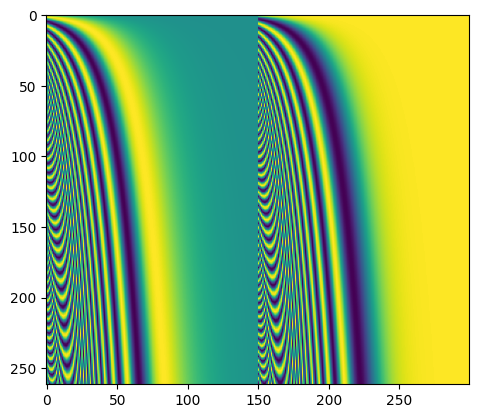

In [155]:
import matplotlib.pyplot as plt
plt.imshow(positional_encoding(seq_len,d_model))

In [157]:
posEmb = PositionalEmbedding(vocab_size,seq_len,d_model).to('cuda')
input_tensor = torch.randint(0,vocab_size,(batch_size, seq_len)).to('cuda')
print(input_tensor.shape)
output_tensor = posEmb(input_tensor)
print(output_tensor.shape)

torch.Size([16, 262])
torch.Size([16, 262, 300])


In [189]:
class Decoder(nn.Module):
    def __init__(self,d_model,n_heads):
        super(Decoder,self).__init__()
        self.attention = nn.MultiheadAttention(d_model,n_heads,batch_first=True)
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model,d_model*4),
            nn.GELU(),
            nn.Linear(d_model*4,d_model),
            nn.Dropout(0.5)
        )
        self.q = nn.Linear(d_model,d_model)
        self.k = nn.Linear(d_model,d_model)
        self.v = nn.Linear(d_model,d_model)
        
    def forward(self,x):
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        attention_output,_ = self.attention(q,k,v,is_causal=True,attn_mask=nn.Transformer.generate_square_subsequent_mask(x.size(1)).to('cuda'),need_weights=False)
        x = x + attention_output
        x = self.layer_norm1(x)
        ffn_out = self.feed_forward(x)
        x = x + ffn_out
        return x

In [190]:
class GPT(nn.Module):
    def __init__(self,d_model,n_heads,vocab_size,seq_len):
        super(GPT,self).__init__()
        self.layers = nn.Sequential()
        self.embedding = PositionalEmbedding(vocab_size,seq_len,d_model)
        for _ in range(12):
            self.layers.append(Decoder(d_model,n_heads))
        
        self.layer_norm = nn.LayerNorm(d_model)
        self.final_layer = nn.Linear(d_model,vocab_size)
            
    def forward(self,x):
        x = self.embedding(x)
        x = self.layers(x)
        x = self.layer_norm(x)
        x = self.final_layer(x)
        return x

In [191]:
input_tensor = torch.randint(0,vocab_size,(batch_size, seq_len)).to('cuda')
print(input_tensor.shape)
gpt = GPT(d_model,n_heads,vocab_size,seq_len).to('cuda')
output = gpt(input_tensor)
print(output.shape)
softmax_tensor = F.softmax(output, dim=2)
print(softmax_tensor.shape)

torch.Size([16, 262])
torch.Size([16, 262, 8000])
torch.Size([16, 262, 8000])


In [260]:
def masked_loss(label, pred):
    ce_loss = F.cross_entropy(pred.permute(0,2,1), label, ignore_index=0)
    mask = (label != 0).float()
    total_loss = torch.sum(ce_loss * mask.view(-1)) / torch.sum(mask)
    return total_loss

def masked_accuracy(label, pred):
    pred = pred.argmax(dim=2)
    match = label.eq(pred)
    mask = label.ne(0)
    match = match & mask
    match = match.float()
    mask = mask.float()
    return match.sum() / mask.sum()

In [258]:
print(masked_loss(input_tensor,softmax_tensor))
print(masked_accuracy(input_tensor,softmax_tensor))

tensor(8.9872, device='cuda:0')
tensor(0.0002, device='cuda:0')


In [261]:
gpt = GPT(d_model,n_heads,vocab_size,seq_len).to('cuda')
optimizer = torch.optim.Adam(gpt.parameters())

In [262]:
from tqdm import tqdm
for epoch in range(2):
    total_loss = 0
    total_accuracy = 0
    
    for batch_idx, data in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        data = data.to('cuda')
        output = gpt(data)
        output = F.softmax(output,dim=2)
        loss = masked_loss(data, output)
        accuracy = masked_accuracy(data, output)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_accuracy += accuracy.item()
        
        if batch_idx % 100 == 99:
            print('Epoch {} [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'.format(
                epoch+1, batch_idx+1, len(train_loader), total_loss / 100, total_accuracy / 100))
            total_loss = 0.0
            total_accuracy = 0.0

print('Training finished!')

100it [00:25,  3.89it/s]

Epoch 1 [100/3125], Loss: 8.9195, Accuracy: 0.0730


200it [00:50,  4.10it/s]

Epoch 1 [200/3125], Loss: 8.9150, Accuracy: 0.0723


300it [01:15,  4.11it/s]

Epoch 1 [300/3125], Loss: 8.9156, Accuracy: 0.0718


400it [01:39,  4.05it/s]

Epoch 1 [400/3125], Loss: 8.9152, Accuracy: 0.0721


500it [02:04,  4.03it/s]

Epoch 1 [500/3125], Loss: 8.9134, Accuracy: 0.0741


600it [02:29,  4.11it/s]

Epoch 1 [600/3125], Loss: 8.9109, Accuracy: 0.0765


700it [02:53,  4.05it/s]

Epoch 1 [700/3125], Loss: 8.9095, Accuracy: 0.0788


800it [03:18,  4.08it/s]

Epoch 1 [800/3125], Loss: 8.9426, Accuracy: 0.0449


900it [03:42,  4.04it/s]

Epoch 1 [900/3125], Loss: 8.9499, Accuracy: 0.0376


1000it [04:07,  4.07it/s]

Epoch 1 [1000/3125], Loss: 8.9498, Accuracy: 0.0377


1100it [04:32,  4.08it/s]

Epoch 1 [1100/3125], Loss: 8.9500, Accuracy: 0.0375


1200it [04:56,  4.06it/s]

Epoch 1 [1200/3125], Loss: 8.9509, Accuracy: 0.0366


1300it [05:21,  4.07it/s]

Epoch 1 [1300/3125], Loss: 8.9502, Accuracy: 0.0373


1400it [05:45,  4.07it/s]

Epoch 1 [1400/3125], Loss: 8.9504, Accuracy: 0.0371


1500it [06:10,  4.09it/s]

Epoch 1 [1500/3125], Loss: 8.9508, Accuracy: 0.0367


1600it [06:34,  4.06it/s]

Epoch 1 [1600/3125], Loss: 8.9502, Accuracy: 0.0373


1700it [06:59,  4.11it/s]

Epoch 1 [1700/3125], Loss: 8.9508, Accuracy: 0.0367


1800it [07:24,  4.07it/s]

Epoch 1 [1800/3125], Loss: 8.9499, Accuracy: 0.0376


1900it [07:48,  4.06it/s]

Epoch 1 [1900/3125], Loss: 8.9498, Accuracy: 0.0377


2000it [08:13,  4.06it/s]

Epoch 1 [2000/3125], Loss: 8.9497, Accuracy: 0.0377


2100it [08:37,  4.08it/s]

Epoch 1 [2100/3125], Loss: 8.9513, Accuracy: 0.0362


2200it [09:02,  4.08it/s]

Epoch 1 [2200/3125], Loss: 8.9494, Accuracy: 0.0381


2300it [09:26,  4.08it/s]

Epoch 1 [2300/3125], Loss: 8.9498, Accuracy: 0.0377


2400it [09:51,  4.09it/s]

Epoch 1 [2400/3125], Loss: 8.9496, Accuracy: 0.0379


2500it [10:15,  4.05it/s]

Epoch 1 [2500/3125], Loss: 8.9506, Accuracy: 0.0369


2600it [10:40,  4.10it/s]

Epoch 1 [2600/3125], Loss: 8.9503, Accuracy: 0.0372


2700it [11:04,  4.10it/s]

Epoch 1 [2700/3125], Loss: 8.9496, Accuracy: 0.0378


2800it [11:29,  4.04it/s]

Epoch 1 [2800/3125], Loss: 8.9504, Accuracy: 0.0371


2900it [11:53,  4.07it/s]

Epoch 1 [2900/3125], Loss: 8.9503, Accuracy: 0.0372


3000it [12:18,  4.05it/s]

Epoch 1 [3000/3125], Loss: 8.9501, Accuracy: 0.0373


3100it [12:43,  4.07it/s]

Epoch 1 [3100/3125], Loss: 8.9499, Accuracy: 0.0376


3125it [12:49,  4.06it/s]
100it [00:24,  4.10it/s]

Epoch 2 [100/3125], Loss: 8.9502, Accuracy: 0.0373


200it [00:49,  4.09it/s]

Epoch 2 [200/3125], Loss: 8.9504, Accuracy: 0.0371


300it [01:13,  4.08it/s]

Epoch 2 [300/3125], Loss: 8.9509, Accuracy: 0.0365


400it [01:38,  4.07it/s]

Epoch 2 [400/3125], Loss: 8.9499, Accuracy: 0.0375


500it [02:02,  4.07it/s]

Epoch 2 [500/3125], Loss: 8.9506, Accuracy: 0.0368


600it [02:27,  4.07it/s]

Epoch 2 [600/3125], Loss: 8.9506, Accuracy: 0.0369


700it [02:51,  4.07it/s]

Epoch 2 [700/3125], Loss: 8.9503, Accuracy: 0.0372


800it [03:16,  4.06it/s]

Epoch 2 [800/3125], Loss: 8.9506, Accuracy: 0.0369


900it [03:40,  4.02it/s]

Epoch 2 [900/3125], Loss: 8.9502, Accuracy: 0.0373


1000it [04:05,  4.10it/s]

Epoch 2 [1000/3125], Loss: 8.9505, Accuracy: 0.0370


1100it [04:29,  4.07it/s]

Epoch 2 [1100/3125], Loss: 8.9501, Accuracy: 0.0374


1200it [04:54,  4.08it/s]

Epoch 2 [1200/3125], Loss: 8.9501, Accuracy: 0.0373


1300it [05:19,  4.07it/s]

Epoch 2 [1300/3125], Loss: 8.9504, Accuracy: 0.0371


1400it [05:43,  4.03it/s]

Epoch 2 [1400/3125], Loss: 8.9497, Accuracy: 0.0377


1500it [06:08,  4.06it/s]

Epoch 2 [1500/3125], Loss: 8.9495, Accuracy: 0.0380


1600it [06:32,  4.09it/s]

Epoch 2 [1600/3125], Loss: 8.9499, Accuracy: 0.0376


1700it [06:57,  4.04it/s]

Epoch 2 [1700/3125], Loss: 8.9504, Accuracy: 0.0370


1800it [07:21,  4.03it/s]

Epoch 2 [1800/3125], Loss: 8.9500, Accuracy: 0.0375


1900it [07:46,  4.09it/s]

Epoch 2 [1900/3125], Loss: 8.9502, Accuracy: 0.0372


2000it [08:10,  4.07it/s]

Epoch 2 [2000/3125], Loss: 8.9502, Accuracy: 0.0373


2100it [08:35,  4.03it/s]

Epoch 2 [2100/3125], Loss: 8.9494, Accuracy: 0.0380


2200it [09:00,  4.10it/s]

Epoch 2 [2200/3125], Loss: 8.9496, Accuracy: 0.0378


2300it [09:24,  4.04it/s]

Epoch 2 [2300/3125], Loss: 8.9513, Accuracy: 0.0362


2400it [09:49,  4.08it/s]

Epoch 2 [2400/3125], Loss: 8.9499, Accuracy: 0.0376


2500it [10:13,  4.11it/s]

Epoch 2 [2500/3125], Loss: 8.9496, Accuracy: 0.0379


2600it [10:38,  4.05it/s]

Epoch 2 [2600/3125], Loss: 8.9501, Accuracy: 0.0374


2700it [11:02,  4.05it/s]

Epoch 2 [2700/3125], Loss: 8.9510, Accuracy: 0.0365


2800it [11:27,  4.10it/s]

Epoch 2 [2800/3125], Loss: 8.9512, Accuracy: 0.0363


2900it [11:51,  4.09it/s]

Epoch 2 [2900/3125], Loss: 8.9504, Accuracy: 0.0370


3000it [12:16,  4.08it/s]

Epoch 2 [3000/3125], Loss: 8.9504, Accuracy: 0.0371


3100it [12:40,  4.08it/s]

Epoch 2 [3100/3125], Loss: 8.9512, Accuracy: 0.0363


3125it [12:47,  4.07it/s]

Training finished!


In [118]:
input_text = "it is"
tokens = tokenizer.Encode([input_text],add_bos=True, add_eos=True)
new_tokens = [tokens[0][:-1] + [0]*(seq_len-len(tokens[0])) + [2]]
tokenized_input = torch.tensor(new_tokens).to('cuda')
padded_input = torch.nn.utils.rnn.pad_sequence(tokenized_input, batch_first=True, padding_value=0).to('cuda')
print(padded_input.shape)
output = gpt(padded_input)
softmax_tensor = F.softmax(output, dim=2)
top_k = 1
top_probs, top_indices = torch.topk(softmax_tensor, k=top_k, dim=2)
print(" ".join([tokenizer.Decode(t) for t in top_indices[0].view(-1).detach().tolist()]))

torch.Size([1, 262])
 the was is the the the the the the the the the the the the the the the the the the the the the the the the the    the the the                                                                                                                                                                                                                                   


In [263]:
def generate(prompt='', max_len=262, k=1):
    prompt = preprocess(prompt)
    input_ids = tokenizer.Encode([prompt],add_bos=True)
    input_ids[0] = input_ids[0] + [0]*(max_len - len(input_ids[0]))
    input_ids = torch.tensor(input_ids, dtype=torch.long).to('cuda')
    output_ids = []
    
    for i in range(max_len):
        with torch.no_grad():
            predictions = gpt(input_ids)
        predictions = F.softmax(predictions, dim=2)
        top_k_preds = torch.topk(predictions, k, dim=2)[1][0].detach().tolist()
        
        pred_idx = random.choice(top_k_preds[i])
        if pred_idx == tokenizer.eos_id():
            break
        output_ids.append(int(pred_idx))
        pred_idx = torch.tensor([[pred_idx]], dtype=torch.long)
        input_ids[0][i]=pred_idx
    
    output_seq = tokenizer.Decode(output_ids)
    return output_seq

In [271]:
prompt = 'He is not going'
print(prompt + ' '+generate(prompt, k=2))

He is not going in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in
